# 1. Assignment: CIFAR-10 Classification

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import datetime

%load_ext tensorboard

2023-12-10 16:24:34.865166: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-10 16:24:34.955338: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-10 16:24:34.955386: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-10 16:24:34.955442: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-10 16:24:35.121578: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-10 16:24:35.130687: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
SHUFFLE_BUFFER_SIZE = 1000
BATCH_SIZE = 64
LEARNING_RATE = 0.001

## 1.1 Prepare the Dataset

First familiarise yourself with the dataset. It is included as a TensorFlow
Dataset but can also be obtained from other sources. Try to understand how it
works (information in the data, dataset size, image size, are there color chan-
nels, type the data is stored as, etc.). Understanding the data you are working
with and applying respective preprocessing steps is a major part of the process
for real life applications.
Now that you familiarised yourself with it, load the data and apply respective
preprocessing steps using a data pipeline (In case of problems refer to your old
homework tasks or the Courseware). 1 Visualize a sample of the dataset

### Familiarize with dataset and visualize samples

tfds.core.DatasetInfo(
    name='cifar10',
    full_name='cifar10/3.0.2',
    description="""
    The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.
    """,
    homepage='https://www.cs.toronto.edu/~kriz/cifar.html',
    data_dir='/home/lena/tensorflow_datasets/cifar10/3.0.2',
    file_format=tfrecord,
    download_size=162.17 MiB,
    dataset_size=132.40 MiB,
    features=FeaturesDict({
        'id': Text(shape=(), dtype=string),
        'image': Image(shape=(32, 32, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=10),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'test': <SplitInfo num_examples=10000, num_shards=1>,
        'train': <SplitInfo num_examples=50000, num_shards=1>,
    },
    citation="""@TECHREPORT{Krizhevsky09learningmultiple,
        author = {Alex Krizhevsky},
        title = {L

2023-12-10 16:25:48.491432: W tensorflow/core/kernels/data/cache_dataset_ops.cc:854] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


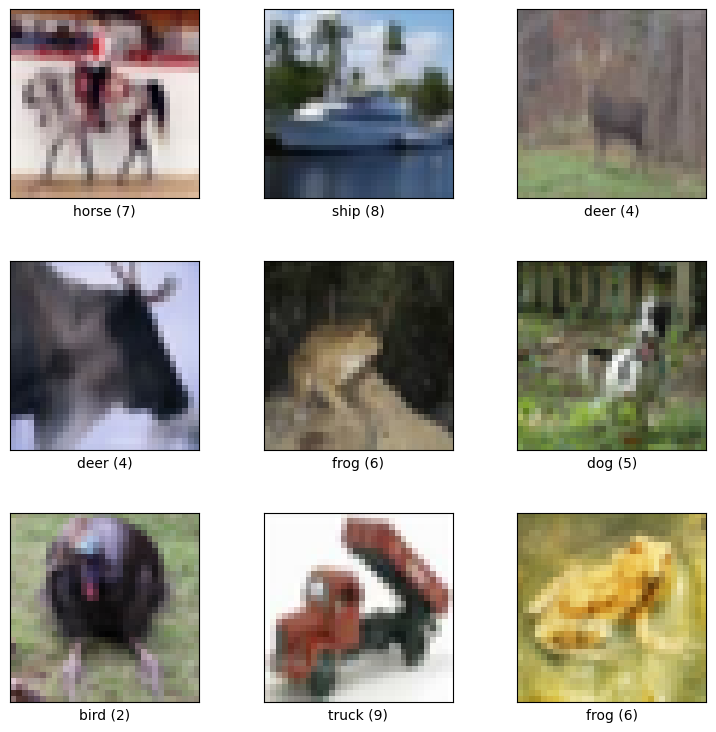

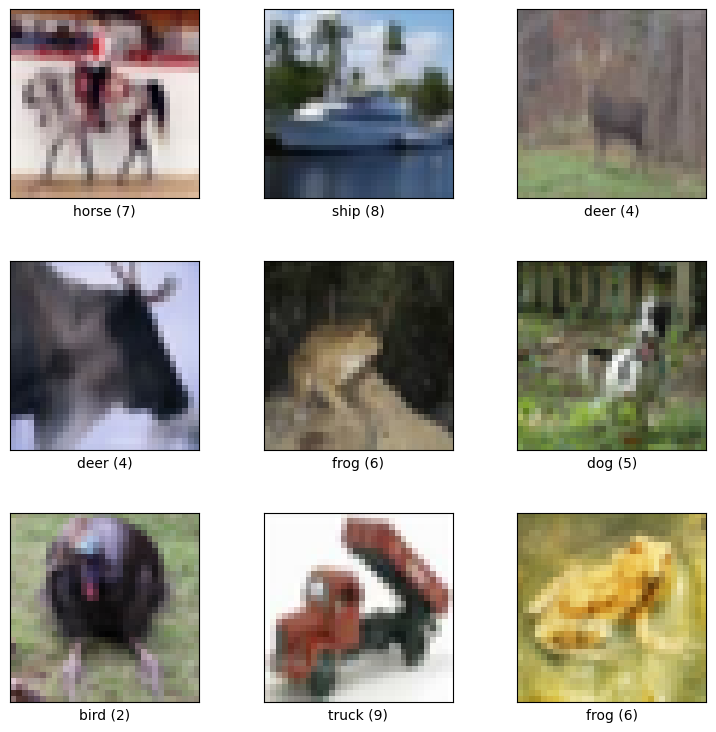

In [5]:
(train_data, test_data), ds_info = tfds.load(name='cifar10',
                                                split=['train','test'],
                                                as_supervised=True,
                                                with_info=True)
print(ds_info)
tfds.show_examples(train_data, ds_info)

### Prepare preprocessing

In [6]:
def preprocessing(img,label):
    img = tf.cast(img, tf.float32)
    img = (img/128) -1
    label = tf.one_hot(label, depth=10)
    return img, label


def load_and_prep_cifar(batch_size, shuffle_buffer_size):
    (train_data, test_data), ds_info = tfds.load(name='cifar10',
                                                split=['train','test'],
                                                as_supervised=True,
                                                with_info=True)
    train_data = train_data.map(lambda img, label: preprocessing(img,label))
    test_data = test_data.map(lambda img, label: preprocessing(img,label))
    train_data = train_data.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(20)
    test_data = test_data.batch(batch_size).prefetch(20)
    return train_data, test_data, ds_info

In [7]:
train_data, test_data, ds_info = load_and_prep_cifar(batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE)

## 1.2 The CNN Model

Build a Convolutional Neural Network inspired by the information gained in
this weeks Courseware. You are going to need more than the dense-layers used
so far. Start with a basic structure and don’t necessarily think about optimizing
the architecture too much, as this will be part of the last step. 

In [21]:
class CNN_Model(tf.keras.Model):
    def __init__(self, size_of_blocks: [int], lr, opt):
        super(CNN_Model, self).__init__()
        
        if opt == 'sgd':
            self.optimizer = tf.keras.optimizers.legacy.SGD(learning_rate=lr)
        else:
            self.optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=lr)
        
        self.metrics_list = [
                        tf.keras.metrics.Mean(name="loss"),
                        tf.keras.metrics.CategoricalAccuracy(name="acc"),
                       ]
        
        self.loss_f = tf.keras.losses.CategoricalCrossentropy()
        
        self.model_layers = []
        
        for block in range(len(size_of_blocks)):
            self.model_layers.append(tf.keras.layers.Conv2D(activation="relu", filters=size_of_blocks[block], kernel_size=3, padding="same"))
            self.model_layers.append(tf.keras.layers.Conv2D(activation="relu", filters=size_of_blocks[block], kernel_size=3, padding="same"))
            self.model_layers.append(tf.keras.layers.Conv2D(activation="relu", filters=size_of_blocks[block], kernel_size=3, padding="same"))
            self.model_layers.append(tf.keras.layers.AvgPool2D(pool_size=(2,2), strides=(2,2)))
        self.global_pooling = tf.keras.layers.GlobalAveragePooling2D()
        self.output_layer = tf.keras.layers.Dense(10, activation='softmax')
       
    @tf.function
    def call(self, x):
        for layer in self.model_layers:
            x = layer(x)
        x = self.global_pooling(x)
        output = self.output_layer(x)
        return output
    
    def reset_metrics(self):
        for metric in self.metrics_list:
            metric.reset_states()
            
            
    @tf.function
    def train_step(self, data):
        x, target = data
        with tf.GradientTape() as tape:
            pred = self(x)
            loss = self.loss_f(target, pred) + tf.reduce_sum(self.losses)
        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(grads_and_vars=zip(gradients, self.trainable_variables))
        
        self.metrics[0].update_state(loss)
        
        for metric in self.metrics[1:]:
            metric.update_state(target, pred)
        return {m.name: m.result() for m in self.metrics}
    
    @tf.function
    def test_step(self, data):
        x, target = data
        pred = self(x)
        loss = self.loss_f(target, pred) + tf.reduce_sum(self.losses)
        
        self.metrics[0].update_state(loss)
        
        for metric in self.metrics[1:]:
            metric.update_state(target, pred)
        return {m.name: m.result() for m in self.metrics}

In [22]:
model = CNN_Model(size_of_blocks=[5,10,32,64], lr=LEARNING_RATE, opt='adam')

## 1.3 Training the network

Define a training loop function. Define your hyperparameters, think of an ap-
propriate loss function and optimizer and initialize everything. Store loss and
accuracy for training and test data. Training your network for a maximum of
15 epochs should be enough.

In [23]:
# Define where to save the log
config_name= "Run-1"
current_time_run1 = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

train_log_path = f"logs/{config_name}/{current_time_run1}/train"
test_log_path = f"logs/{config_name}/{current_time_run1}/val"

# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)

# log writer for validation metrics
test_summary_writer = tf.summary.create_file_writer(test_log_path)

In [24]:
import tqdm

def training_loop(model, train, test, epochs, train_summary_writer, test_summary_writer):
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    for epoch in range(epochs):
        
        #Training
        for data in tqdm.tqdm(train, position=0, leave=True, desc=f"Epoch {epoch}"):
            metrics = model.train_step(data)
            with train_summary_writer.as_default():
                for metric in model.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)
        
        train_loss.append(metrics["loss"].numpy())
        train_acc.append(metrics["acc"].numpy())
        
        # print the metrics
        print([f"{key}: {value.numpy()}" for (key, value) in metrics.items()])
        
        # reset all metrics (requires a reset_metrics method in the model)
        model.reset_metrics()

        # Validation:
        for data in test:
            metrics = model.test_step(data)

            # logging the validation metrics to the log file which is used by tensorboard
            with test_summary_writer.as_default():
                for metric in model.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)
        
        val_loss.append(metrics["loss"].numpy())
        val_acc.append(metrics["acc"].numpy())
        print([f"val_{key}: {value.numpy()}" for (key, value) in metrics.items()])

        # reset all metrics
        model.reset_metrics()
    return train_loss, train_acc, val_loss, val_acc

In [12]:
train, test, info = load_and_prep_cifar(batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE)
model = CNN_Model(size_of_blocks=[5,10,32,64], lr=LEARNING_RATE, opt='adam')
train_losses, train_accuracies, val_losses, val_accuracies = training_loop(model, train, test, 15, train_summary_writer, test_summary_writer)

Epoch 0:   0%|          | 0/782 [00:00<?, ?it/s]2023-12-10 16:43:34.278430: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 27371520 exceeds 10% of free system memory.
2023-12-10 16:43:34.278504: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 27371520 exceeds 10% of free system memory.
2023-12-10 16:43:34.289334: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 27371520 exceeds 10% of free system memory.
2023-12-10 16:43:34.289667: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 27371520 exceeds 10% of free system memory.
2023-12-10 16:43:34.294552: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 24975360 exceeds 10% of free system memory.
Epoch 0: 100%|██████████| 782/782 [01:32<00:00,  8.46it/s]


['loss: 1.8090336322784424', 'acc: 0.31446000933647156']
['val_loss: 1.5978044271469116', 'val_acc: 0.40400001406669617']


Epoch 1: 100%|██████████| 782/782 [01:25<00:00,  9.12it/s]


['loss: 1.491885781288147', 'acc: 0.4465000033378601']
['val_loss: 1.4582901000976562', 'val_acc: 0.4645000100135803']


Epoch 2: 100%|██████████| 782/782 [01:31<00:00,  8.53it/s]


['loss: 1.3436474800109863', 'acc: 0.5074999928474426']
['val_loss: 1.3574589490890503', 'val_acc: 0.512499988079071']


Epoch 3: 100%|██████████| 782/782 [01:32<00:00,  8.41it/s]


['loss: 1.2368848323822021', 'acc: 0.5516800284385681']
['val_loss: 1.275145173072815', 'val_acc: 0.5328999757766724']


Epoch 4: 100%|██████████| 782/782 [01:22<00:00,  9.46it/s]


['loss: 1.1547993421554565', 'acc: 0.5838199853897095']
['val_loss: 1.1776041984558105', 'val_acc: 0.5685999989509583']


Epoch 5: 100%|██████████| 782/782 [01:24<00:00,  9.28it/s]


['loss: 1.0850821733474731', 'acc: 0.6110799908638']
['val_loss: 1.1260045766830444', 'val_acc: 0.5976999998092651']


Epoch 6: 100%|██████████| 782/782 [01:24<00:00,  9.30it/s]


['loss: 1.0240638256072998', 'acc: 0.6351400017738342']
['val_loss: 1.079417109489441', 'val_acc: 0.6172999739646912']


Epoch 7: 100%|██████████| 782/782 [01:21<00:00,  9.63it/s]


['loss: 0.9776492118835449', 'acc: 0.6500999927520752']
['val_loss: 1.0600969791412354', 'val_acc: 0.6187999844551086']


Epoch 8: 100%|██████████| 782/782 [01:17<00:00, 10.03it/s]


['loss: 0.9193351864814758', 'acc: 0.6711599826812744']
['val_loss: 1.019763469696045', 'val_acc: 0.6345000267028809']


Epoch 9: 100%|██████████| 782/782 [02:21<00:00,  5.51it/s]


['loss: 0.8743873834609985', 'acc: 0.6897799968719482']
['val_loss: 0.9903087019920349', 'val_acc: 0.6488000154495239']


Epoch 10: 100%|██████████| 782/782 [01:13<00:00, 10.71it/s]


['loss: 0.8372126817703247', 'acc: 0.7029399871826172']
['val_loss: 1.0225602388381958', 'val_acc: 0.6446999907493591']


Epoch 11: 100%|██████████| 782/782 [01:28<00:00,  8.80it/s]


['loss: 0.7956023812294006', 'acc: 0.7183799743652344']
['val_loss: 1.017392635345459', 'val_acc: 0.6531999707221985']


Epoch 12: 100%|██████████| 782/782 [01:26<00:00,  9.01it/s]


['loss: 0.7547393441200256', 'acc: 0.7307999730110168']
['val_loss: 1.0116727352142334', 'val_acc: 0.6525999903678894']


Epoch 13: 100%|██████████| 782/782 [01:26<00:00,  9.02it/s]


['loss: 0.7181053757667542', 'acc: 0.7453399896621704']
['val_loss: 1.0476723909378052', 'val_acc: 0.6520000100135803']


Epoch 14: 100%|██████████| 782/782 [01:23<00:00,  9.36it/s]


['loss: 0.6823307275772095', 'acc: 0.7578200101852417']
['val_loss: 1.0374747514724731', 'val_acc: 0.6574000120162964']


## 1.4 Visualization

After training visualize the performance of your model and the values that you
collected during training and testing.

In [13]:
%tensorboard --logdir logs

In [25]:
import matplotlib.pyplot as plt
def visualization (train_losses, train_accuracies, val_losses, val_accuracies):
    """ Visualizes accuracy and loss for training and test data using
        the mean of each epoch.
        
        Loss is displayed in a regular line, accuracy in a dotted line.
        Training data is displayed in blue, test data in red.
    
    Parameters
    ----------
    train_losses : numpy . ndarray
    training losses
    train_accuracies : numpy . ndarray
    training accuracies
    val_losses : numpy . ndarray
    val losses
    val_accuracies : numpy . ndarray
    val accuracies
    """
    #plt.figure()
    line1, = plt.plot(train_losses, "b-")
    line2, = plt.plot(val_losses, "r-")
    line3, = plt.plot(train_accuracies, "b:")
    line4, = plt.plot(val_accuracies, "r:")
    plt.xlabel("Training steps")
    plt.ylabel("Loss / Accuracy")
    plt.legend((line1, line2, line3, line4), ("training loss", "validation loss", "train accuracy", "validation accuracy"))
    plt.show()

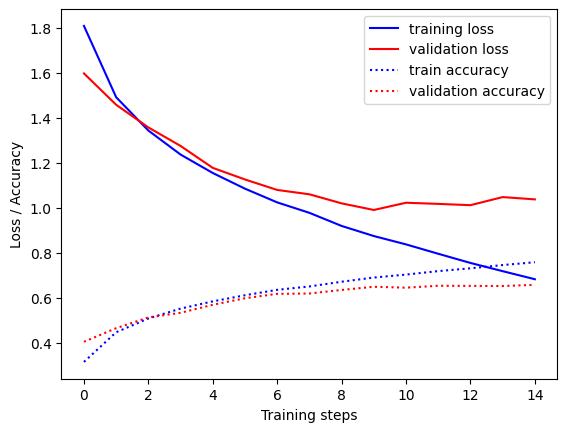

In [26]:
visualization(train_losses, train_accuracies, val_losses, val_accuracies)

# 2 Adjust hyperparameters and architecture

Now it is time to learn about the influence hyperparameter and training choices
can make. Try out:
- Two different Learning Rates
- Two different Architectures (e.g. number and size of layers)
- Two different optimizers (Including Adam and one other)

In total this should create 8 respective settings, for each of which we ask you to plot:
- Training Accuracy
- Training Loss
- Test Accuracy
- Test Loss

To be explicit: This should result in a total of 8 times four plots!

## 2.1 Learning Rate Experiments

In [ ]:
'''
1. Experiment

Learning rate: 0.0001
Architecture: [5,10,32,64]
Optimizer: Adam
'''

LEARNING_RATE = 0.0001

train, test, info = load_and_prep_cifar(batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE)
model = CNN_Model(size_of_blocks=[5,10,32,64], lr=LEARNING_RATE, opt='adam')

# Define where to save the log
config_name= "Run-2"
train_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/train'
test_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/val'
# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)
# log writer for validation metrics
test_summary_writer = tf.summary.create_file_writer(test_log_path)


train_losses, train_accuracies, val_losses, val_accuracies = training_loop(model, train, test, 15, train_summary_writer, test_summary_writer)
visualization(train_losses, train_accuracies, val_losses, val_accuracies)

Epoch 0: 100%|██████████| 782/782 [01:30<00:00,  8.64it/s]


['loss: 2.0307960510253906', 'acc: 0.23617999255657196']
['val_loss: 1.8984266519546509', 'val_acc: 0.30329999327659607']


Epoch 1: 100%|██████████| 782/782 [01:23<00:00,  9.42it/s]


['loss: 1.8486762046813965', 'acc: 0.3108600080013275']
['val_loss: 1.7851181030273438', 'val_acc: 0.33709999918937683']


Epoch 2: 100%|██████████| 782/782 [01:27<00:00,  8.96it/s]


['loss: 1.7560995817184448', 'acc: 0.34384000301361084']
['val_loss: 1.7189313173294067', 'val_acc: 0.3596999943256378']


Epoch 3: 100%|██████████| 782/782 [01:34<00:00,  8.25it/s]


['loss: 1.698427677154541', 'acc: 0.3682200014591217']
['val_loss: 1.6663624048233032', 'val_acc: 0.3714999854564667']


Epoch 4: 100%|██████████| 782/782 [01:28<00:00,  8.83it/s]


['loss: 1.6671617031097412', 'acc: 0.379940003156662']
['val_loss: 1.630771517753601', 'val_acc: 0.3901999890804291']


Epoch 5: 100%|██████████| 782/782 [01:27<00:00,  8.90it/s]


['loss: 1.6351732015609741', 'acc: 0.3937000036239624']
['val_loss: 1.6053894758224487', 'val_acc: 0.4009999930858612']


Epoch 6: 100%|██████████| 782/782 [01:30<00:00,  8.67it/s]


['loss: 1.6061553955078125', 'acc: 0.4062800109386444']
['val_loss: 1.5907889604568481', 'val_acc: 0.4036000072956085']


Epoch 7: 100%|██████████| 782/782 [01:21<00:00,  9.57it/s]


['loss: 1.5770719051361084', 'acc: 0.4205400049686432']
['val_loss: 1.5531214475631714', 'val_acc: 0.4185999929904938']


Epoch 8: 100%|██████████| 782/782 [01:38<00:00,  7.95it/s]


['loss: 1.5498936176300049', 'acc: 0.42965999245643616']
['val_loss: 1.5239275693893433', 'val_acc: 0.43309998512268066']


Epoch 9: 100%|██████████| 782/782 [01:44<00:00,  7.49it/s]


['loss: 1.5277067422866821', 'acc: 0.43904000520706177']
['val_loss: 1.5388175249099731', 'val_acc: 0.4277999997138977']


Epoch 10: 100%|██████████| 782/782 [01:38<00:00,  7.97it/s]


['loss: 1.4998410940170288', 'acc: 0.4519599974155426']
['val_loss: 1.4908654689788818', 'val_acc: 0.4512999951839447']


Epoch 11:  73%|███████▎  | 567/782 [01:08<00:25,  8.32it/s]


KeyboardInterrupt: 

Epoch 0: 100%|██████████| 782/782 [00:17<00:00, 44.16it/s]


['loss: 1.8598732948303223', 'acc: 0.29183998703956604']
['val_loss: 1.6192256212234497', 'val_acc: 0.3887999951839447']


Epoch 1: 100%|██████████| 782/782 [00:14<00:00, 54.32it/s]


['loss: 1.5487109422683716', 'acc: 0.4203999936580658']
['val_loss: 1.4341483116149902', 'val_acc: 0.4683000147342682']


Epoch 2: 100%|██████████| 782/782 [00:14<00:00, 52.80it/s]


['loss: 1.422119140625', 'acc: 0.47275999188423157']
['val_loss: 1.3593934774398804', 'val_acc: 0.5002999901771545']


Epoch 3: 100%|██████████| 782/782 [00:14<00:00, 54.03it/s]


['loss: 1.3277804851531982', 'acc: 0.5133799910545349']
['val_loss: 1.3015772104263306', 'val_acc: 0.5296000242233276']


Epoch 4: 100%|██████████| 782/782 [00:14<00:00, 54.88it/s]


['loss: 1.2491528987884521', 'acc: 0.5443000197410583']
['val_loss: 1.2317754030227661', 'val_acc: 0.5523999929428101']


Epoch 5: 100%|██████████| 782/782 [00:14<00:00, 54.69it/s]


['loss: 1.182219386100769', 'acc: 0.5677400231361389']
['val_loss: 1.2308429479599', 'val_acc: 0.553600013256073']


Epoch 6: 100%|██████████| 782/782 [00:14<00:00, 54.03it/s]


['loss: 1.1231564283370972', 'acc: 0.5932199954986572']
['val_loss: 1.175776720046997', 'val_acc: 0.5776000022888184']


Epoch 7: 100%|██████████| 782/782 [00:14<00:00, 54.48it/s]


['loss: 1.0692341327667236', 'acc: 0.6116799712181091']
['val_loss: 1.1826609373092651', 'val_acc: 0.5848000049591064']


Epoch 8: 100%|██████████| 782/782 [00:14<00:00, 54.35it/s]


['loss: 1.0154614448547363', 'acc: 0.6328799724578857']
['val_loss: 1.2605117559432983', 'val_acc: 0.570900022983551']


Epoch 9: 100%|██████████| 782/782 [00:14<00:00, 54.90it/s]


['loss: 0.9715712666511536', 'acc: 0.6523600220680237']
['val_loss: 1.183947205543518', 'val_acc: 0.5896000266075134']


Epoch 10: 100%|██████████| 782/782 [00:14<00:00, 54.80it/s]


['loss: 0.9279906749725342', 'acc: 0.6650800108909607']
['val_loss: 1.1554746627807617', 'val_acc: 0.6011000275611877']


Epoch 11: 100%|██████████| 782/782 [00:14<00:00, 54.88it/s]


['loss: 0.8843156099319458', 'acc: 0.6826599836349487']
['val_loss: 1.1980006694793701', 'val_acc: 0.5985000133514404']


Epoch 12: 100%|██████████| 782/782 [00:14<00:00, 55.06it/s]


['loss: 0.8474069833755493', 'acc: 0.6945400238037109']
['val_loss: 1.2344093322753906', 'val_acc: 0.5981000065803528']


Epoch 13: 100%|██████████| 782/782 [00:14<00:00, 55.65it/s]


['loss: 0.8087280988693237', 'acc: 0.709879994392395']
['val_loss: 1.2284693717956543', 'val_acc: 0.6065999865531921']


Epoch 14: 100%|██████████| 782/782 [00:14<00:00, 55.33it/s]


['loss: 0.7818881273269653', 'acc: 0.7202799916267395']
['val_loss: 1.2485380172729492', 'val_acc: 0.5978999733924866']


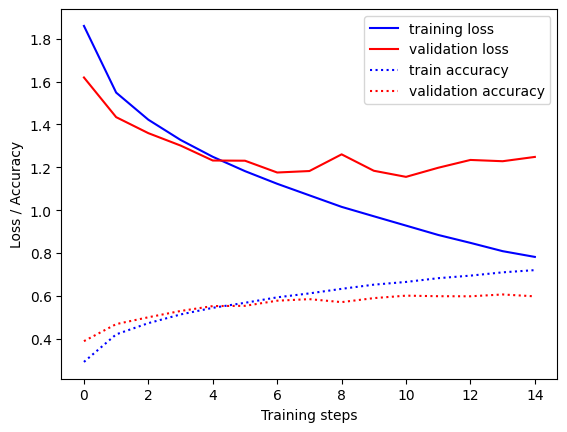

In [25]:
'''
2. Experiment

Learning rate: 0.002
Architecture: [5,10,32,64]
Optimizer: Adam
'''

LEARNING_RATE = 0.002

train, test, info = load_and_prep_cifar(batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE)
model = CNN_Model(size_of_blocks=[5,10,32,64], lr=LEARNING_RATE, opt='adam')

# Define where to save the log
config_name= "Run-2"
train_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/train'
test_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/val'
# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)
# log writer for validation metrics
test_summary_writer = tf.summary.create_file_writer(test_log_path)


train_losses, train_accuracies, val_losses, val_accuracies = training_loop(model, train, test, 15, train_summary_writer, test_summary_writer)
visualization(train_losses, train_accuracies, val_losses, val_accuracies)

## 2.2 Architecture Experiments

Epoch 0: 100%|██████████| 782/782 [00:44<00:00, 17.38it/s]


['loss: 1.8029841184616089', 'acc: 0.3089999854564667']
['val_loss: 1.515753149986267', 'val_acc: 0.43070000410079956']


Epoch 1: 100%|██████████| 782/782 [00:41<00:00, 19.07it/s]


['loss: 1.3819096088409424', 'acc: 0.4796000123023987']
['val_loss: 1.2846962213516235', 'val_acc: 0.5300999879837036']


Epoch 2: 100%|██████████| 782/782 [00:40<00:00, 19.10it/s]


['loss: 1.1080169677734375', 'acc: 0.5950800180435181']
['val_loss: 1.003694772720337', 'val_acc: 0.6427000164985657']


Epoch 3: 100%|██████████| 782/782 [00:40<00:00, 19.17it/s]


['loss: 0.8962334394454956', 'acc: 0.6807399988174438']
['val_loss: 0.8614586591720581', 'val_acc: 0.6998000144958496']


Epoch 4: 100%|██████████| 782/782 [00:40<00:00, 19.10it/s]


['loss: 0.7575491666793823', 'acc: 0.7311599850654602']
['val_loss: 0.7724742293357849', 'val_acc: 0.7312999963760376']


Epoch 5: 100%|██████████| 782/782 [00:40<00:00, 19.14it/s]


['loss: 0.6528398394584656', 'acc: 0.7690200209617615']
['val_loss: 0.7511382102966309', 'val_acc: 0.7422000169754028']


Epoch 6: 100%|██████████| 782/782 [00:40<00:00, 19.20it/s]


['loss: 0.5596224665641785', 'acc: 0.8050400018692017']
['val_loss: 0.677054226398468', 'val_acc: 0.7736999988555908']


Epoch 7: 100%|██████████| 782/782 [00:40<00:00, 19.17it/s]


['loss: 0.4764876365661621', 'acc: 0.8337000012397766']
['val_loss: 0.7422841787338257', 'val_acc: 0.758899986743927']


Epoch 8: 100%|██████████| 782/782 [00:40<00:00, 19.18it/s]


['loss: 0.41575103998184204', 'acc: 0.8540800213813782']
['val_loss: 0.7302079796791077', 'val_acc: 0.7770000100135803']


Epoch 9: 100%|██████████| 782/782 [00:40<00:00, 19.24it/s]


['loss: 0.3506126403808594', 'acc: 0.875760018825531']
['val_loss: 0.7638360857963562', 'val_acc: 0.7736999988555908']


Epoch 10: 100%|██████████| 782/782 [00:40<00:00, 19.13it/s]


['loss: 0.305695503950119', 'acc: 0.8930400013923645']
['val_loss: 0.7469496726989746', 'val_acc: 0.7797999978065491']


Epoch 11: 100%|██████████| 782/782 [00:40<00:00, 19.34it/s]


['loss: 0.27218300104141235', 'acc: 0.9050400257110596']
['val_loss: 0.8124292492866516', 'val_acc: 0.777999997138977']


Epoch 12: 100%|██████████| 782/782 [00:39<00:00, 19.68it/s]


['loss: 0.2416338324546814', 'acc: 0.9154000282287598']
['val_loss: 0.8518152832984924', 'val_acc: 0.7811999917030334']


Epoch 13: 100%|██████████| 782/782 [00:39<00:00, 19.60it/s]


['loss: 0.2081640660762787', 'acc: 0.9272800087928772']
['val_loss: 0.9558848738670349', 'val_acc: 0.7793999910354614']


Epoch 14: 100%|██████████| 782/782 [00:39<00:00, 19.67it/s]


['loss: 0.19202175736427307', 'acc: 0.93367999792099']
['val_loss: 0.9116576313972473', 'val_acc: 0.7843999862670898']


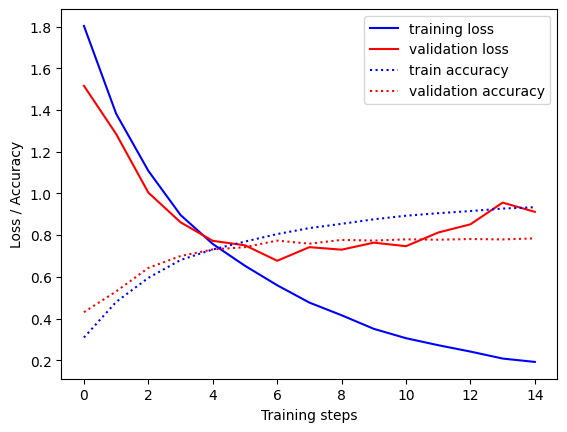

In [35]:
'''
3. Experiment

Learning rate: 0.0001
Architecture: [64,164,164,64]
Optimizer: Adam
'''

LEARNING_RATE = 0.0001

train, test, info = load_and_prep_cifar(batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE)
model = CNN_Model(size_of_blocks=[64,164,164,64], lr=LEARNING_RATE, opt='adam')

# Define where to save the log
config_name= "Run-2"
train_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/train'
test_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/val'
# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)
# log writer for validation metrics
test_summary_writer = tf.summary.create_file_writer(test_log_path)


train_losses, train_accuracies, val_losses, val_accuracies = training_loop(model, train, test, 15, train_summary_writer, test_summary_writer)
visualization(train_losses, train_accuracies, val_losses, val_accuracies)

Epoch 0: 100%|██████████| 782/782 [00:22<00:00, 34.41it/s]


['loss: 1.7697027921676636', 'acc: 0.3205600082874298']
['val_loss: 1.5529356002807617', 'val_acc: 0.424699991941452']


Epoch 1: 100%|██████████| 782/782 [00:18<00:00, 42.24it/s]


['loss: 1.354454517364502', 'acc: 0.49588000774383545']
['val_loss: 1.276078462600708', 'val_acc: 0.5343999862670898']


Epoch 2: 100%|██████████| 782/782 [00:18<00:00, 42.78it/s]


['loss: 1.120073914527893', 'acc: 0.5926399827003479']
['val_loss: 1.0925346612930298', 'val_acc: 0.6169000267982483']


Epoch 3: 100%|██████████| 782/782 [00:18<00:00, 41.53it/s]


['loss: 0.9614388942718506', 'acc: 0.6556000113487244']
['val_loss: 0.9367771148681641', 'val_acc: 0.6717000007629395']


Epoch 4: 100%|██████████| 782/782 [00:19<00:00, 39.72it/s]


['loss: 0.8454731106758118', 'acc: 0.6985999941825867']
['val_loss: 0.8314602375030518', 'val_acc: 0.7077000141143799']


Epoch 5: 100%|██████████| 782/782 [00:19<00:00, 40.52it/s]


['loss: 0.7559739351272583', 'acc: 0.7333599925041199']
['val_loss: 0.8253053426742554', 'val_acc: 0.7085000276565552']


Epoch 6: 100%|██████████| 782/782 [00:18<00:00, 41.19it/s]


['loss: 0.6944558024406433', 'acc: 0.7553399801254272']
['val_loss: 0.8099132180213928', 'val_acc: 0.7178000211715698']


Epoch 7: 100%|██████████| 782/782 [00:19<00:00, 40.98it/s]


['loss: 0.63563472032547', 'acc: 0.776639997959137']
['val_loss: 0.7567692399024963', 'val_acc: 0.7409999966621399']


Epoch 8: 100%|██████████| 782/782 [00:19<00:00, 39.61it/s]


['loss: 0.5864667296409607', 'acc: 0.792140007019043']
['val_loss: 0.7486013174057007', 'val_acc: 0.7488999962806702']


Epoch 9: 100%|██████████| 782/782 [00:19<00:00, 39.72it/s]


['loss: 0.5416117906570435', 'acc: 0.8085799813270569']
['val_loss: 0.7140911817550659', 'val_acc: 0.7645999789237976']


Epoch 10: 100%|██████████| 782/782 [00:19<00:00, 39.77it/s]


['loss: 0.5079504251480103', 'acc: 0.8215000033378601']
['val_loss: 0.7614522576332092', 'val_acc: 0.7531999945640564']


Epoch 11: 100%|██████████| 782/782 [00:19<00:00, 39.51it/s]


['loss: 0.47215256094932556', 'acc: 0.8322799801826477']
['val_loss: 0.718571662902832', 'val_acc: 0.767300009727478']


Epoch 12: 100%|██████████| 782/782 [00:19<00:00, 39.52it/s]


['loss: 0.4389728307723999', 'acc: 0.8424400091171265']
['val_loss: 0.7161195278167725', 'val_acc: 0.7688000202178955']


Epoch 13: 100%|██████████| 782/782 [00:19<00:00, 39.72it/s]


['loss: 0.41579410433769226', 'acc: 0.8524399995803833']
['val_loss: 0.774641752243042', 'val_acc: 0.7645000219345093']


Epoch 14: 100%|██████████| 782/782 [00:19<00:00, 39.48it/s]


['loss: 0.390516072511673', 'acc: 0.8622599840164185']
['val_loss: 0.7662436962127686', 'val_acc: 0.7706000208854675']


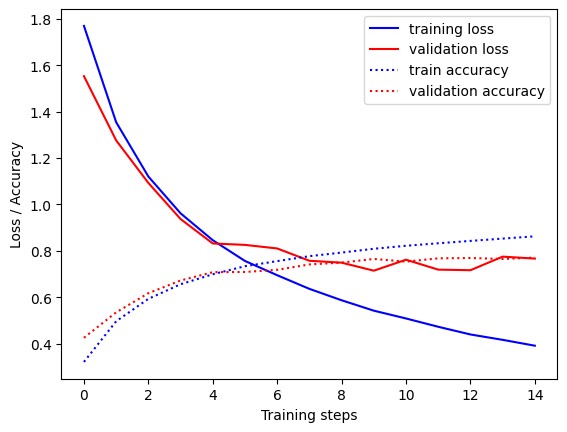

In [38]:
'''
4. Experiment

Learning rate: 0.002
Architecture: [64,164,164,64]
Optimizer: Adam
'''

LEARNING_RATE = 0.002

train, test, info = load_and_prep_cifar(batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE)
model = CNN_Model(size_of_blocks=[64,32,32,64], lr=LEARNING_RATE, opt='adam')

# Define where to save the log
config_name= "Run-2"
train_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/train'
test_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/val'
# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)
# log writer for validation metrics
test_summary_writer = tf.summary.create_file_writer(test_log_path)


train_losses, train_accuracies, val_losses, val_accuracies = training_loop(model, train, test, 15, train_summary_writer, test_summary_writer)
visualization(train_losses, train_accuracies, val_losses, val_accuracies)

## 2.3 Optimizer Experiments

In [27]:
'''
5. Experiment

Learning rate: 0.0001
Architecture: [5,10,32,64]
Optimizer: SGD
'''

LEARNING_RATE = 0.0001
opt='sgd'

train, test, info = load_and_prep_cifar(batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE)
model = CNN_Model(size_of_blocks=[5,10,32,64], lr=LEARNING_RATE, opt=opt)

# Define where to save the log
config_name= "Run-2"
train_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/train'
test_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/val'
# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)
# log writer for validation metrics
test_summary_writer = tf.summary.create_file_writer(test_log_path)


train_losses, train_accuracies, val_losses, val_accuracies = training_loop(model, train, test, 15, train_summary_writer, test_summary_writer)
visualization(train_losses, train_accuracies, val_losses, val_accuracies)

Epoch 0: 100%|██████████| 782/782 [01:32<00:00,  8.42it/s]


['loss: 2.0339465141296387', 'acc: 0.22594000399112701']
['val_loss: 1.84651780128479', 'val_acc: 0.3172000050544739']


Epoch 1: 100%|██████████| 782/782 [01:26<00:00,  9.00it/s]


['loss: 1.7830634117126465', 'acc: 0.3287999927997589']
['val_loss: 1.7437207698822021', 'val_acc: 0.3522999882698059']


Epoch 2: 100%|██████████| 782/782 [01:27<00:00,  8.95it/s]


['loss: 1.707218050956726', 'acc: 0.359279990196228']
['val_loss: 1.7225844860076904', 'val_acc: 0.3637999892234802']


Epoch 3: 100%|██████████| 782/782 [01:15<00:00, 10.30it/s]


['loss: 1.6629945039749146', 'acc: 0.37731999158859253']
['val_loss: 1.6346653699874878', 'val_acc: 0.38440001010894775']


Epoch 4: 100%|██████████| 782/782 [01:15<00:00, 10.40it/s]


['loss: 1.6362704038619995', 'acc: 0.38947999477386475']
['val_loss: 1.6038641929626465', 'val_acc: 0.39559999108314514']


Epoch 5: 100%|██████████| 782/782 [01:14<00:00, 10.56it/s]


['loss: 1.6112735271453857', 'acc: 0.39862000942230225']
['val_loss: 1.5944900512695312', 'val_acc: 0.4034999907016754']


Epoch 6: 100%|██████████| 782/782 [01:17<00:00, 10.09it/s]


['loss: 1.5867842435836792', 'acc: 0.4078800082206726']
['val_loss: 1.569516658782959', 'val_acc: 0.40610000491142273']


Epoch 7: 100%|██████████| 782/782 [01:14<00:00, 10.45it/s]


['loss: 1.5725642442703247', 'acc: 0.4131599962711334']
['val_loss: 1.600224256515503', 'val_acc: 0.4083999991416931']


Epoch 8: 100%|██████████| 782/782 [01:21<00:00,  9.55it/s]


['loss: 1.5551263093948364', 'acc: 0.4212400019168854']
['val_loss: 1.5252351760864258', 'val_acc: 0.4277999997138977']


Epoch 9: 100%|██████████| 782/782 [01:13<00:00, 10.65it/s]


['loss: 1.5402594804763794', 'acc: 0.42767998576164246']
['val_loss: 1.5306241512298584', 'val_acc: 0.42820000648498535']


Epoch 10: 100%|██████████| 782/782 [01:21<00:00,  9.55it/s]


['loss: 1.52316153049469', 'acc: 0.43386000394821167']
['val_loss: 1.5088731050491333', 'val_acc: 0.43560001254081726']


Epoch 11: 100%|██████████| 782/782 [01:14<00:00, 10.55it/s]


['loss: 1.504575490951538', 'acc: 0.4421199858188629']
['val_loss: 1.4848651885986328', 'val_acc: 0.44190001487731934']


Epoch 12:  43%|████▎     | 338/782 [00:45<00:59,  7.44it/s]


KeyboardInterrupt: 

In [ ]:
'''
6. Experiment

Learning rate: 0.002
Architecture: [5,10,32,64]
Optimizer: SGD
'''

LEARNING_RATE = 0.002
opt='sgd'

train, test, info = load_and_prep_cifar(batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE)
model = CNN_Model(size_of_blocks=[5,10,32,64], lr=LEARNING_RATE, opt=opt)

# Define where to save the log
config_name= "Run-2"
train_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/train'
test_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/val'
# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)
# log writer for validation metrics
test_summary_writer = tf.summary.create_file_writer(test_log_path)


train_losses, train_accuracies, val_losses, val_accuracies = training_loop(model, train, test, 15, train_summary_writer, test_summary_writer)
visualization(train_losses, train_accuracies, val_losses, val_accuracies)

In [ ]:
'''
7. Experiment

Learning rate: 0.0001
Architecture: [64,164,164,64]
Optimizer: SGD
'''

LEARNING_RATE = 0.0001
opt='sgd'

train, test, info = load_and_prep_cifar(batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE)
model = CNN_Model(size_of_blocks=[64,164,164,64], lr=LEARNING_RATE, opt=opt)

# Define where to save the log
config_name= "Run-2"
train_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/train'
test_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/val'
# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)
# log writer for validation metrics
test_summary_writer = tf.summary.create_file_writer(test_log_path)


train_losses, train_accuracies, val_losses, val_accuracies = training_loop(model, train, test, 15, train_summary_writer, test_summary_writer)
visualization(train_losses, train_accuracies, val_losses, val_accuracies)

In [ ]:
'''
8. Experiment

Learning rate: 0.002
Architecture: [64,164,164,64]
Optimizer: SGD
'''

LEARNING_RATE = 0.002
opt='sgd'

train, test, info = load_and_prep_cifar(batch_size=BATCH_SIZE, shuffle_buffer_size=SHUFFLE_BUFFER_SIZE)
model = CNN_Model(size_of_blocks=[64,164,164,64], lr=LEARNING_RATE, opt=opt)

# Define where to save the log
config_name= "Run-2"
train_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/train'
test_log_path = f'logs/{config_name}/{datetime.datetime.now().strftime("%Y%m%d-%H%M%S")}/val'
# log writer for training metrics
train_summary_writer = tf.summary.create_file_writer(train_log_path)
# log writer for validation metrics
test_summary_writer = tf.summary.create_file_writer(test_log_path)


train_losses, train_accuracies, val_losses, val_accuracies = training_loop(model, train, test, 15, train_summary_writer, test_summary_writer)
visualization(train_losses, train_accuracies, val_losses, val_accuracies)